In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load("Pretrained_models/firework_growing.pt")

for param in old_CA.parameters():
   param.requires_grad = False

Successfully loaded model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


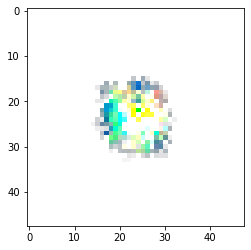

In [5]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 1, old_CA, iter_func=ExponentialSampler(max=50))
pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

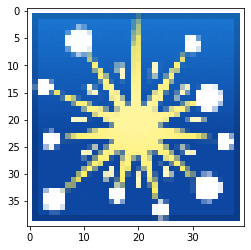

In [6]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [7]:
# Send target to device
target = target.to(device)

In [8]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load("Pretrained_models/mask 80% correct.pt")
model = VirusCA(old_CA, new_CA, mutation_probability=0.8)

Successfully loaded model!


In [25]:
# Train the model
wandb.init()
wandb.watch(model, log_freq=64)

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=2e-3)
criterion = NCALoss(pad(target, TARGET_PADDING))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=120, scheduler=scheduler, kind="persist", skip_update=2, skip_damage=2)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 48, 48])) that is different to the input size (torch.Size([4, 4, 48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [16]:
model.mutation_probability = 0.8

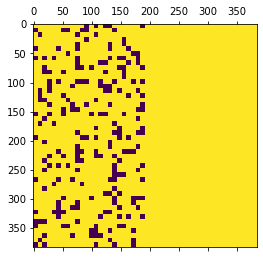

In [22]:
img = T.Resize(48*8, T.InterpolationMode.NEAREST)(model.new_cells).cpu()
pl.matshow(img[0, 0])
save_image(GrayscaletoCmap(img[0, 0]), "mask new 2.png")
#pl.axis('off')
#pl.savefig("mask 90%.png")

In [18]:
new_mask = model.new_cells.clone()
new_mask[:, :, :, 24:] = 1.
model.set_cell_mask(new_mask)

In [ ]:
# Show losses
model.plot_losses()

In [ ]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

In [ ]:
# Save the model and upload it to wandb
model.new_CA.save("Pretrained_models/mask 70% \regen no_padding.pt")

wandb.log({"state_dict": model.new_CA.state_dict()})
wandb.save("Pretrained_models/mask 70% \regen no_padding.pt")

In [ ]:
# Upload pool images to wandb
imgs = []

for i in range(12):
    img = np.asarray(pool.sample(1)[0][0].cpu().permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

In [ ]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [ ]:
# Upload mask to wandb
wandb.log({"mask": wandb.Image(model.new_cells.cpu()[0,0])})

In [21]:
# Make a switch video
_ , _ = switch_video(old_CA, model, fname="mask 70%.mp4")

In [20]:
# Upload the evolution video to wandb
wandb.log({"video": wandb.Video("prova.mp4", "video", fps=10, format="mp4")})

FileNotFoundError: [Errno 2] No such file or directory: 'prova.mp4'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


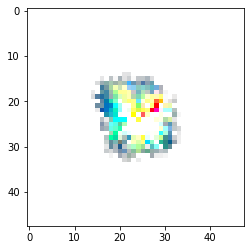

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


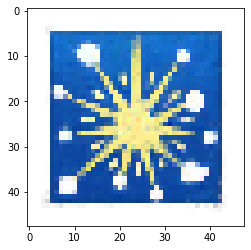

In [17]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    for i in range(250):
        x = model.forward(x)

imshow(x[0].cpu())

img = T.Resize(48*8, T.InterpolationMode.NEAREST)(x[0:1]).cpu()
save_image(RGBAtoRGB(img[:, :4])/255, "mask new 2.png")

In [ ]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))

In [ ]:
wandb.finish()